# Improving Neural Net Performance
**Suggested time to spend on exercise**: 20 minutes

In this exercise, we will focus on improving the performance of the NN we trained in the previous exercise. Normalizing the features is particularly important to obtaining good performance. Another way is by trying different optimization algorithms. Note that neither of these methods are specific to neural networks - they are effective means to improve most types of models.

First, we'll load the data.

In [0]:
#@test {"output": "ignore"}

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.google as tf
from IPython import display
from google3.pyglib import gfile
from sklearn import metrics


def preprocess_features(california_housing_dataframe):
  """This function takes an input dataframe and returns a version of it that has
  various features selected and pre-processed.  The input dataframe is expected
  to contain data from the california_housing data set."""
  processed_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housingMedianAge",
     "totalRooms",
     "totalBedrooms",
     "population",
     "households",
     "medianIncome"]].copy()
  processed_features["roomsPerPerson"] = (
    california_housing_dataframe["totalRooms"] /
    california_housing_dataframe["population"])
  # Feel free to add other synthetic features here.
  return processed_features


def preprocess_targets(california_housing_dataframe):
  """This function selects and potentially transforms the output target from
  a dataframe containing data from the california_housing data set.  Object
  returned is a pandas Series."""
  processed_targets = pd.DataFrame()
    # Scale the target to be in units of thousands of dollars.
  processed_targets["medianHouseValue"] = (
    california_housing_dataframe["medianHouseValue"] / 1000.0)
  return processed_targets


# Load in the raw data.  Note that there's a separate test data set that we
# will leave untouched for now.
raw_training_df = pd.read_csv(
  gfile.Open("/placer/prod/home/ami/mlcc/california_housing/v1/train.csv"),
  sep=",")
# Randomize the data before selecting train / validation splits.
raw_training_df = raw_training_df.reindex(
  np.random.permutation(raw_training_df.index))

# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(raw_training_df.head(12000))
training_targets = preprocess_targets(raw_training_df.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(raw_training_df.tail(5000))
validation_targets = preprocess_targets(raw_training_df.tail(5000))

Next, we train our NN.

Training model...
RMSE:
  period 00 : 162.15
  period 01 : 155.13
  period 02 : 145.53
  period 03 : 132.94
  period 04 : 120.61
  period 05 : 111.90
  period 06 : 106.54
  period 07 : 105.74
  period 08 : 105.47
  period 09 : 105.31
Final RMSE (on training data):   105.31
Final RMSE (on validation data): 105.81


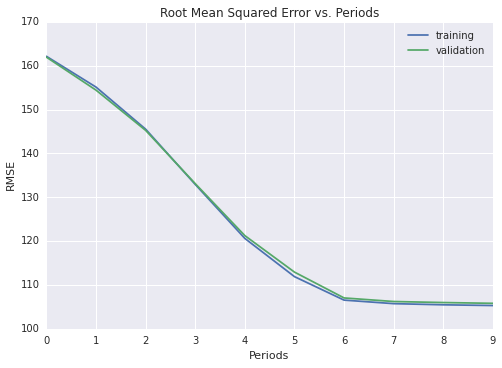

In [0]:
#@test {"output": "ignore", "timeout": 180}

LEARNING_RATE = 0.0007  # @param
STEPS = 5000  # @param
BATCH_SIZE = 70  # @param
HIDDEN_UNITS = [10, 10]  # @param
periods = 10
steps_per_period = STEPS / periods

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model..."
print "RMSE:"
root_mean_squared_errors_training = []
root_mean_squared_errors_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(validation_examples)
  predictions_training = dnn_regressor.predict(training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  root_mean_squared_errors_validation.append(root_mean_squared_error_validation)
  root_mean_squared_errors_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(root_mean_squared_errors_training, label='training')
plt.plot(root_mean_squared_errors_validation, label='validation')
plt.legend()

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

### Task 1: Normalize the features using linear scaling.

**Normalize the inputs to the scale -1, 1.  You can use the helper method in the following cell.**

**Spend about 5 minutes training and evaluating on the newly normalized data.  How well can you do?**

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

Sanity check your normalized data.  (What would happen if you forgot to normalize one feature?)


In [0]:
#@test {"output": "ignore"}

def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [0]:
#
# Your code here: normalize the inputs and retrain the network.
#

Training model...
RMSE:
  period 00 : 165.01
  period 01 : 115.29
  period 02 : 105.37
  period 03 : 90.73
  period 04 : 78.39
  period 05 : 74.85
  period 06 : 73.23
  period 07 : 72.15
  period 08 : 71.36
  period 09 : 70.76
Model training finished.
Final RMSE (on training data):   70.76
Final RMSE (on validation data): 72.76


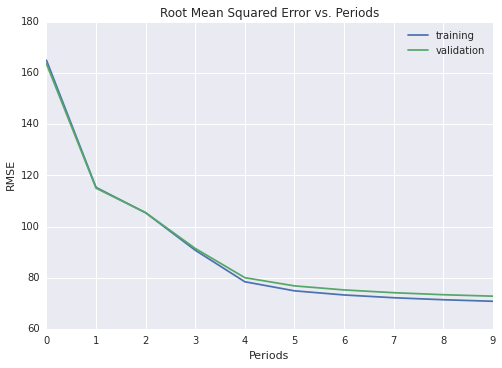

In [0]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore", "timeout": 180}

LEARNING_RATE = 0.005
STEPS = 2000
BATCH_SIZE = 50
HIDDEN_UNITS = [10, 10]
periods = 10
steps_per_period = STEPS / periods

#
# Solution: normalize all inputs using linear_scale.
#
def normalize_linear_scale(examples_dataframe):
  """This function takes an input dataframe and returns a version of it that has
  all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housingMedianAge"] = linear_scale(examples_dataframe["housingMedianAge"])
  processed_features["totalRooms"] = linear_scale(examples_dataframe["totalRooms"])
  processed_features["totalBedrooms"] = linear_scale(examples_dataframe["totalBedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["medianIncome"] = linear_scale(examples_dataframe["medianIncome"])
  processed_features["roomsPerPerson"] = linear_scale(examples_dataframe["roomsPerPerson"])
  return processed_features

# Since normalization uses min and max, we have to ensure it's done on the
# entire dataset at once. We can do that here because all our data is in a
# single DataFrame. If we had multiple data sets, a good practice would be
# to derive the normalization parameters from the training set and apply
# those identically to the test set.
normalized_training_df = normalize_linear_scale(preprocess_features(raw_training_df))
normalized_training_examples = normalized_training_df.head(12000)
normalized_validation_examples = normalized_training_df.tail(5000)

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  normalized_training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model..."
print "RMSE:"
root_mean_squared_errors_training = []
root_mean_squared_errors_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    normalized_training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(normalized_validation_examples)
  predictions_training = dnn_regressor.predict(normalized_training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  root_mean_squared_errors_validation.append(root_mean_squared_error_validation)
  root_mean_squared_errors_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)
print "Model training finished."

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(root_mean_squared_errors_training, label='training')
plt.plot(root_mean_squared_errors_validation, label='validation')
plt.legend()

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

### Task 2: Try a different optimizer.

** Use the Adagrad and RMSProp optimizers and compare performance.**

The Adagrad optimizer is one alternative. The key insight of Adagrad is that it modifies the learning rate adaptively for each coefficient in a model, monotonically lowering the effective learning rate.  This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training.  You can use Adagrad by specifying `AdagradOptimizer` instead of `GradientDescentOptimizer`.  Note that you may need to use a larger learning rate with Adagrad.

Another option is RMSProp, which is similar in spirit to Adagrad but does not monotonically decrease the learning rate.  It can sometimes do a better job of making progress on non-convex optimization.  You can use RMSProp by specifying `RMSPropOptimizer`.  This optimizer has additional hyperparameters, decay and momentum.  We'll leave these set to default values for this experiment, but for a production use they should be carefully tuned.  In the Lab, we'll look at using Vizier to automate tuning of so many knobs.

In [0]:
#
# Your code here: retrain the network using Adagrad and then RMSProp.
#

Training model with Adagrad...
RMSE:
  period 00 : 86.71
  period 01 : 79.43
  period 02 : 76.46
  period 03 : 74.76
  period 04 : 73.43
  period 05 : 69.99
  period 06 : 69.54
  period 07 : 69.05
  period 08 : 68.63
  period 09 : 68.39
Final RMSE (on training data):   68.39
Final RMSE (on validation data): 70.67
Training model with RMSProp...
RMSE:
  period 00 : 211.27
  period 01 : 121.96
  period 02 : 116.33
  period 03 : 110.86
  period 04 : 103.11
  period 05 : 91.05
  period 06 : 76.82
  period 07 : 71.30
  period 08 : 70.68
  period 09 : 70.15
Final RMSE (on training data):   70.15
Final RMSE (on validation data): 72.04


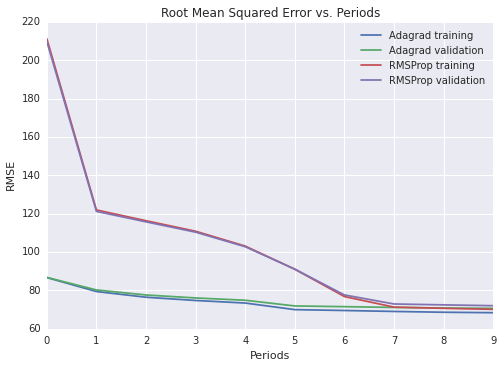

In [0]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore", "timeout": 360}

# We'll keep the number of steps and network structure fixed, for comparison.
HIDDEN_UNITS = [10, 10]
STEPS = 500
periods = 10
steps_per_period = STEPS / periods

#
# Solution: First, let's try Adagrad. Then we'll try RMSProp.
#

LEARNING_RATE = 0.5
BATCH_SIZE = 100

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  normalized_training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model with Adagrad..."
print "RMSE:"
adagrad_rmse_training = []
adagrad_rmse_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    normalized_training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(normalized_validation_examples)
  predictions_training = dnn_regressor.predict(normalized_training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  adagrad_rmse_validation.append(root_mean_squared_error_validation)
  adagrad_rmse_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

#
# Now let's try RMSProp.
#

LEARNING_RATE = 0.01
BATCH_SIZE = 100

# Set up our NN with the desired learning settings.
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.RMSPropOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model with RMSProp..."
print "RMSE:"
rmsprop_rmse_training = []
rmsprop_rmse_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    normalized_training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(normalized_validation_examples)
  predictions_training = dnn_regressor.predict(normalized_training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  rmsprop_rmse_validation.append(root_mean_squared_error_validation)
  rmsprop_rmse_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)
  
# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_rmse_training, label='Adagrad training')
plt.plot(adagrad_rmse_validation, label='Adagrad validation')
plt.plot(rmsprop_rmse_training, label='RMSProp training')
plt.plot(rmsprop_rmse_validation, label='RMSProp validation')
plt.legend()

### Task 3: Explore alternate normalization methods.

**Try alternate normalizations for various features to further improve performance.**

If you look closely at sanity-check summary stats for your transformed data, you may notice that linear scaling some features leaves them clumped close to `-1`.

For example, many features have a median of `-0.8` or so, rather than `0.0`.

We might be able to do better by choosing additional ways to transform these features.

For example, a log scaling might help some features.  Or clipping extreme values may make the remainder of the scale more informative.

The block below contains a few additional possible normalization functions.  Try some of these, or add your own.

Running the cell will also output a histogram for each column, which may help guide your choices.

Note that if you normalize the target, you'll need to un-normalize the predictions for loss metrics to be comparable.

array([[<matplotlib.axes.AxesSubplot object at 0xcce0210>,
        <matplotlib.axes.AxesSubplot object at 0x109ef1d0>]], dtype=object)

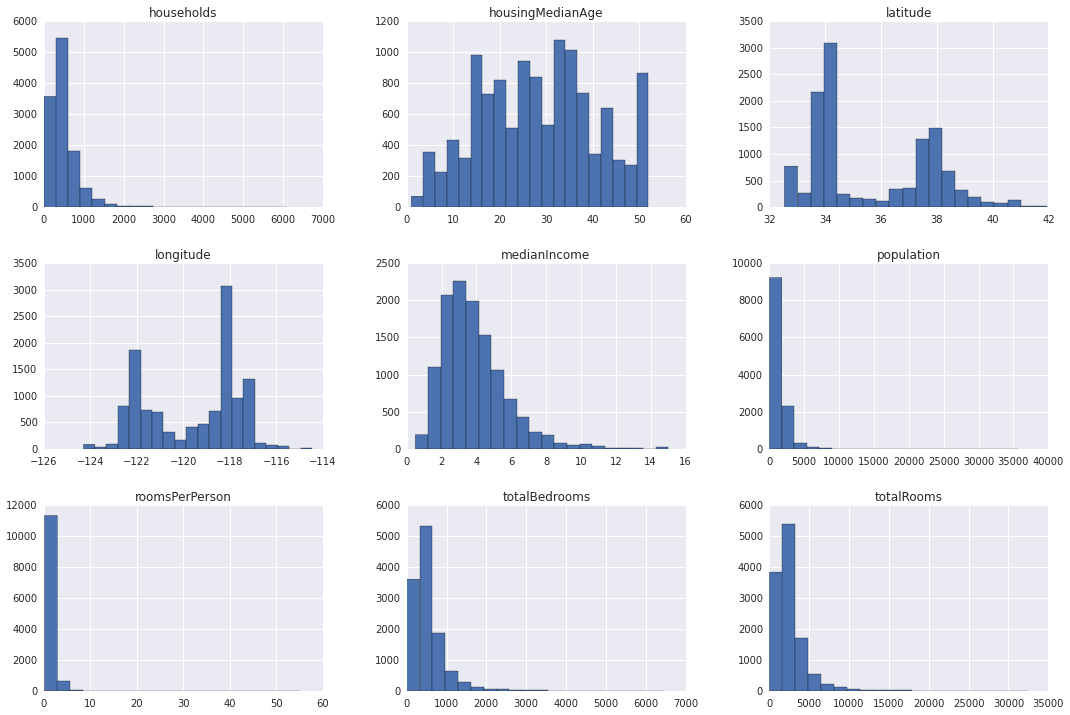

In [0]:
#@test {"output": "ignore"}

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

display.display(training_examples.hist(bins=20, figsize=(18, 12)), xlabelsize=2)


Training model...
RMSE:
  period 00 : 116.74
  period 01 : 98.38
  period 02 : 81.14
  period 03 : 80.20
  period 04 : 79.76
  period 05 : 79.33
  period 06 : 78.88
  period 07 : 78.37
  period 08 : 77.64
  period 09 : 77.13
Model training finished.
Final RMSE (on training data):   77.13
Final RMSE (on validation data): 79.51


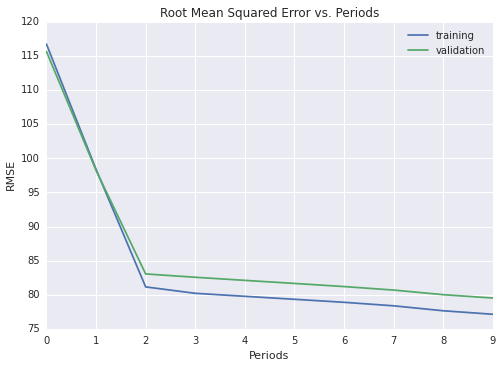

In [0]:
#
# Your code here: normalize the inputs and retrain the network.
##@title To view a possible solution, toggle Form

#@test {"output": "ignore", "timeout": 180}

LEARNING_RATE = 0.005
STEPS = 2000
BATCH_SIZE = 50
HIDDEN_UNITS = [10, 10]
periods = 10
steps_per_period = STEPS / periods

#
# Solution: normalize all inputs using linear_scale.
#
def normalize_linear_scale(examples_dataframe):
  """This function takes an input dataframe and returns a version of it that has
  all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housingMedianAge"] = z_score_normalize(examples_dataframe["housingMedianAge"])
  processed_features["totalRooms"] = linear_scale(clip(examples_dataframe["totalRooms"],0,15000))
  processed_features["totalBedrooms"] = linear_scale(clip(examples_dataframe["totalBedrooms"],0,3000))
  processed_features["population"] = log_normalize(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["medianIncome"] = z_score_normalize(examples_dataframe["medianIncome"])
  processed_features["roomsPerPerson"] = linear_scale(clip(examples_dataframe["roomsPerPerson"],0,10))
  return processed_features

# Since normalization uses min and max, we have to ensure it's done on the
# entire dataset at once. We can do that here because all our data is in a
# single DataFrame. If we had multiple data sets, a good practice would be
# to derive the normalization parameters from the training set and apply
# those identically to the test set.
normalized_training_df = normalize_linear_scale(preprocess_features(raw_training_df))
normalized_training_examples = normalized_training_df.head(12000)
normalized_validation_examples = normalized_training_df.tail(5000)

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  normalized_training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model..."
print "RMSE:"
root_mean_squared_errors_training = []
root_mean_squared_errors_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    normalized_training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(normalized_validation_examples)
  predictions_training = dnn_regressor.predict(normalized_training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  root_mean_squared_errors_validation.append(root_mean_squared_error_validation)
  root_mean_squared_errors_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)
print "Model training finished."

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(root_mean_squared_errors_training, label='training')
plt.plot(root_mean_squared_errors_validation, label='validation')
plt.legend()

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

Training model...
RMSE:
  period 00 : 97.89
  period 01 : 78.49
  period 02 : 75.31
  period 03 : 73.70
  period 04 : 73.08
  period 05 : 72.05
  period 06 : 71.31
  period 07 : 70.44
  period 08 : 70.03
  period 09 : 69.62
Final RMSE (on training data):   69.62
Final RMSE (on validation data): 72.10


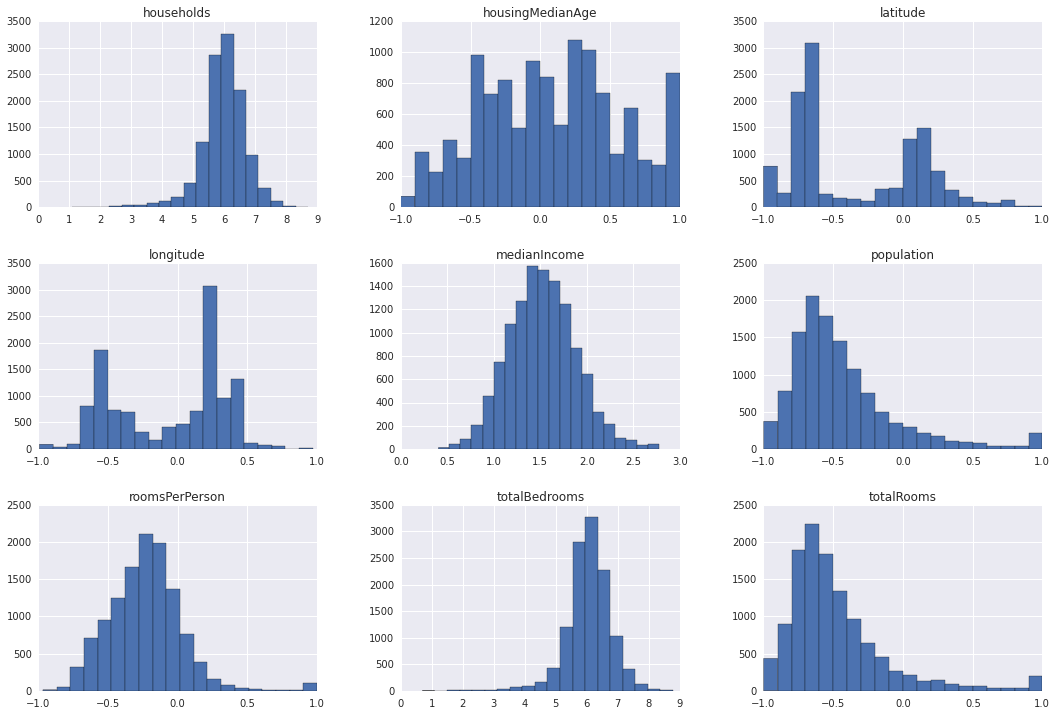

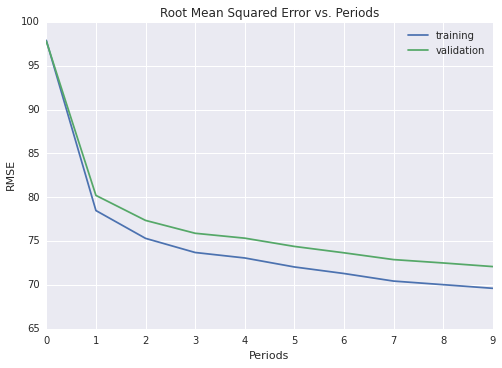

In [0]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore", "timeout": 180}

LEARNING_RATE = 0.15
STEPS = 1000
BATCH_SIZE = 50
HIDDEN_UNITS = [10, 10]
periods = 10
steps_per_period = STEPS / periods

#
# Solution: normalize all inputs appropriately.
#
def normalize(examples_dataframe):
  """This function takes an input dataframe and returns a version of it that has
  all its features normalized for a neural network."""
  processed_features = pd.DataFrame()

  # Below are only a few ways in which we could think about the data.
  # Other transformations may work even better!

  # "households", "medianIncome" and "totalBedrooms" all appear
  # normally-distributed in a log space.
  processed_features["households"] = log_normalize(
    examples_dataframe["households"])
  processed_features["medianIncome"] = log_normalize(
    examples_dataframe["medianIncome"])
  processed_features["totalBedrooms"] = log_normalize(
    examples_dataframe["totalBedrooms"])

  # "latitude", "longitude" and "housingMedianAge" would probably be better
  # off just scaled linearly, as before.
  processed_features["latitude"] = linear_scale(
    examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(
    examples_dataframe["longitude"])
  processed_features["housingMedianAge"] = linear_scale(
    examples_dataframe["housingMedianAge"])

  # "population", "totalRooms" and "roomsPerPerson" have a few extreme
  # outliers. They seem too extreme for log normalization to help. So let's
  # clip them instead.
  processed_features["population"] = linear_scale(
    clip(examples_dataframe["population"], 0, 5000))
  processed_features["roomsPerPerson"] = linear_scale(
    clip(examples_dataframe["roomsPerPerson"], 0, 5))
  processed_features["totalRooms"] = linear_scale(
    clip(examples_dataframe["totalRooms"], 0, 10000))

  return processed_features

# Apply the normalization.
normalized_training_df = normalize(preprocess_features(raw_training_df))
normalized_training_examples = normalized_training_df.head(12000)
normalized_validation_examples = normalized_training_df.tail(5000)

# Plot another histogram to make sure everything looks good.
display.display(normalized_training_examples.hist(bins=20, figsize=(18, 12)), xlabelsize=2)
plt.figure()

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  normalized_training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model..."
print "RMSE:"
root_mean_squared_errors_training = []
root_mean_squared_errors_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    normalized_training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(normalized_validation_examples)
  predictions_training = dnn_regressor.predict(normalized_training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  root_mean_squared_errors_validation.append(root_mean_squared_error_validation)
  root_mean_squared_errors_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(root_mean_squared_errors_training, label='training')
plt.plot(root_mean_squared_errors_validation, label='validation')
plt.legend()

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

### Optional Challenge: Use only latitude and longitude features

**Train a NN model that only uses latitude and longitude as features.**

Real estate people are fond of saying that location is the only important feature in housing price.

See if we can confirm this by attempting the following.

This will only work well if our NN can learn complex nonlinearities from latitude and longitude.

We may need a network structure that has more layers than were useful earlier in the exercise.

In [0]:
#
# Your code here: train the network using only latitude and longitude
#

Training model...
RMSE:
  period 00 : 211.32
  period 05 : 105.51
  period 10 : 102.61
  period 15 : 100.98
Model training finished.
Final RMSE (on training data):   100.32
Final RMSE (on validation data): 100.10

    Well, not bad for just two features! Of course, property values can still
    vary significantly between tiny distances.


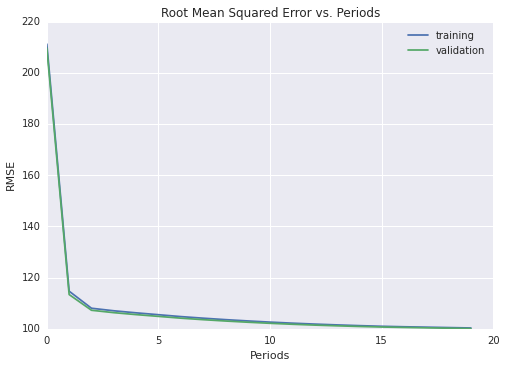

In [0]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore", "timeout": 360}

LEARNING_RATE = 0.05
STEPS = 500
BATCH_SIZE = 50
HIDDEN_UNITS = [10, 10, 5, 5, 5]
periods = 20
steps_per_period = STEPS / periods

#
# Solution: create a DataFrame with just lat and long.
#
def location_location_location(examples_dataframe):
  """This function takes an input dataframe and returns a version of it that
  keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  # It's a good idea to keep them normalized.
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

normalized_training_df = location_location_location(raw_training_df)
normalized_training_examples = normalized_training_df.head(12000)
normalized_validation_examples = normalized_training_df.tail(5000)

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  normalized_training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model..."
print "RMSE:"
root_mean_squared_errors_training = []
root_mean_squared_errors_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    normalized_training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(normalized_validation_examples)
  predictions_training = dnn_regressor.predict(normalized_training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  root_mean_squared_errors_validation.append(root_mean_squared_error_validation)
  root_mean_squared_errors_training.append(root_mean_squared_error_training)

  if period % 5 == 0:
    print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)
print "Model training finished."

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(root_mean_squared_errors_training, label='training')
plt.plot(root_mean_squared_errors_validation, label='validation')
plt.legend()

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation
print """
    Well, not bad for just two features! Of course, property values can still
    vary significantly between tiny distances."""